# Introduction
In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video). This will help us extract topics of discussion. We use the embeddings generated in Assignment 4 as input. (This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/') Each of our comments has been assigned a vector that encodes information about its meaning. The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality. We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them. To do this we reduce the dimensionality of the embeddings again to two dimensions. Then we render a scatterplot of our data.
Furthermore we want to analyze and interpret our clusters. To do this, we:

print some statistics about each of the clusters
print cluster's medoid (the central sample)
print the cluster(s) we want to analyze further
Check to see if jupyter lab uses the correct python interpreter with '!which python'. It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac). If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [53]:
!python --version

Python 3.6.12 :: Anaconda, Inc.


# Install dependencies:

In [54]:
install_packages = True
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



# Imports


In [55]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [56]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')

# Set pandas print options
This will improve readability of printed pandas dataframe.

In [57]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [58]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe. And load the embeddings as a numpy ndarray (a matrix in our case).

In [59]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [60]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP
We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. The number of dimensions (num_dimensions) depends on the number of samples

In [61]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.46483064
n_clusters: 102 silhouette_avg: 0.35518026
n_clusters: 202 silhouette_avg: 0.33745244
n_clusters: 302 silhouette_avg: 0.3145167
n_clusters: 402 silhouette_avg: 0.29311615
n_clusters: 502 silhouette_avg: 0.26001477
n_clusters: 602 silhouette_avg: 0.22029242
n_clusters: 702 silhouette_avg: 0.18041751
n_clusters: 802 silhouette_avg: 0.14012091
n_clusters: 902 silhouette_avg: 0.0828288


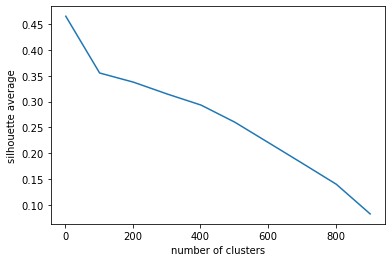

In [62]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [63]:
number_of_clusters =  100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 75     1
24     1
66     1
80     1
98     1
99     2
83     2
86     2
9      2
89     2
43     3
74     3
26     4
84     4
73     4
51     4
90     4
55     4
78     4
5      4
52     5
95     5
46     5
94     5
37     5
68     6
31     6
50     6
65     6
54     6
61     6
38     6
91     6
16     6
59     6
36     7
76     7
21     7
48     7
18     7
58     7
27     7
53     7
71     7
82     7
3      8
63     8
1      8
17     8
64     8
88     8
22     8
20     8
81     8
87     8
7      8
56     9
70     9
14     9
6      9
92     9
42    10
45    11
44    11
33    11
30    11
39    12
10    12
41    12
97    12
67    12
19    13
79    13
85    13
35    14
93    14
49    14
47    15
12    15
29    15
77    16
2     16
0     17
62    17
60    17
40    17
32    17
69    18
15    18
57    19
25    19
23    23
72    23
28    23
96    24
13    25
34    25
11    26
4     29
8     30
Name: label_kmedoids, dtype: int64


In [64]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [ ]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_clustering.fit_transform(embeddings)

# Visualize clustering results

In [ ]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Paired" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)

# Highlight one cluster

In [ ]:
## Choose a cluster to higlight:
cluster_num = 60

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)

# Print Medoids and cluster statistics

In [ ]:
# print the medoids 
data.iloc[medoids_indices]

In [ ]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [ ]:
# Choose a cluster to print
cluster_number =   60
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
    number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to? min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label label_manual: your label

In [ ]:
#which cluster would you like to assign labels to?
cluster_number = 60
#your label
label_manual = ' climate_change_prevention'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [ ]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

# Print Cluster 2

In [ ]:
# Choose a cluster to print
cluster_number =  64
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
    number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster

In [ ]:
#which cluster would you like to assign labels to?
cluster_number = 64
#your label
label_manual = 'global_warming'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [ ]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')